In [56]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

united_states_map = mpimg.imread("/kaggle/input/usamap/united_states_map.png")


In [57]:
def show_cities(path, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]    
    plt.imshow(united_states_map)    
    for x0, y0 in path:
        plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point        
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

    
def show_path(path, starting_city=None, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]
    
    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    #_, (x0, y0) = starting_city
    (x0, y0) = starting_city
    plt.imshow(united_states_map)
    # plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

    
def polyfit_plot(x,y,deg, **kwargs):
    coefficients = np.polyfit(x,y,deg,**kwargs)
    poly  = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "o", new_x, new_y)
    plt.xlim([x[0]-1, x[-1] + 1 ])
    
    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c,1))
        if p == 1: term += 'x'
        if p >= 2: term += 'x^'+str(p)
        terms.append(term)        
    plt.title(" + ".join(reversed(terms)))   

In [58]:
def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str): xy1 = xy1[1]; xy2 = xy2[1];               # if xy1 == ("Name", (x,y))
    return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )

def path_distance(path) -> int:
    if isinstance(path, dict):      path = list(path.values())            # if path == {"Name": (x,y)}
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]   # if path == ("Name", (x,y))
    return int(sum(
        [ distance(path[i],  path[i+1]) for i in range(len(path)-1) ]
      + [ distance(path[-1], path[0]) ]                                   # include cost of return journey
    ))

30


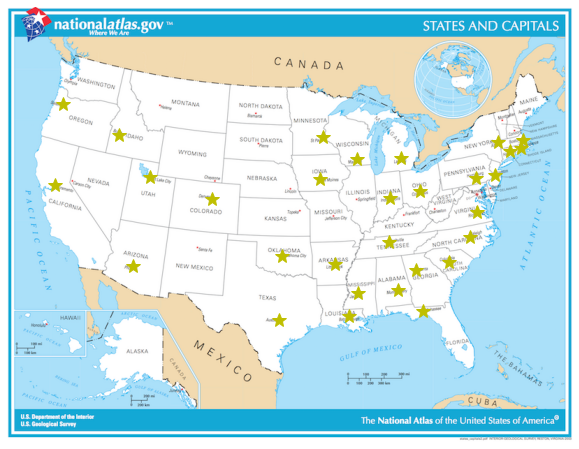

In [59]:
cities = { 
    "Oklahoma City": (392.8, 356.4), 
    "Montgomery": (559.6, 404.8), 
    "Saint Paul": (451.6, 186.0), 
    "Trenton": (698.8, 239.6), 
    "Salt Lake City": (204.0, 243.2), 
    "Columbus": (590.8, 263.2), 
    "Austin": (389.2, 448.4), 
    "Phoenix": (179.6, 371.2), 
    "Hartford": (719.6, 205.2), 
    "Baton Rouge": (489.6, 442.0), 
    "Salem": (80.0, 139.2), 
    "Little Rock": (469.2, 367.2), 
    "Richmond": (673.2, 293.6), 
    "Jackson": (501.6, 409.6), 
    "Des Moines": (447.6, 246.0), 
    "Lansing": (563.6, 216.4), 
    "Denver": (293.6, 274.0), 
    "Boise": (159.6, 182.8), 
    "Raleigh": (662.0, 328.8), 
    "Atlanta": (585.6, 376.8), 
    "Madison": (500.8, 217.6), 
    "Indianapolis": (548.0, 272.8), 
    "Nashville": (546.4, 336.8), 
    "Columbia": (632.4, 364.8), 
    "Providence": (735.2, 201.2), 
    "Boston": (738.4, 190.8), 
    "Tallahassee": (594.8, 434.8), 
    "Sacramento": (68.4, 254.0), 
    "Albany": (702.0, 193.6), 
    "Harrisburg": (670.8, 244.0) 
}
cities = list(sorted(cities.items()))
print(len(cities))
show_cities(cities)

7074

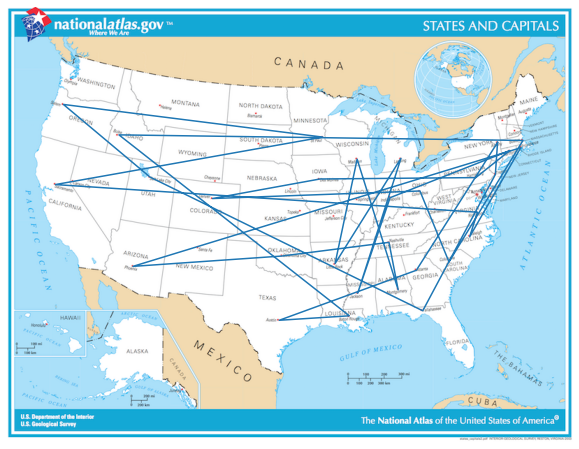

In [60]:
show_path(cities)
path_distance(cities)

In [61]:
import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union

import numpy as np
import random



class AntColonySolver:
    def __init__(self,
                 cost_fn:                 Callable[[Any,Any], Union[float,int]],                         
                 
                 time=0,                  # run for a fixed amount of time
                 min_time=0,              # minimum runtime
                 timeout=0,               # maximum time in seconds to run for
                 stop_factor=2,           # how many times to redouble effort after new new best path
                 min_round_trips=10,      # minimum number of round trips before stopping
                 max_round_trips=0,       # maximum number of round trips before stopping                 
                 min_ants=0,              # Total number of ants to use
                 max_ants=0,              # Total number of ants to use
                 
                 ant_count=64,            # this is the bottom of the near-optimal range for numpy performance
                 ant_speed=1,             # how many steps do ants travel per epoch

                 distance_power=1,        # power to which distance affects pheromones                 
                 pheromone_power=1.25,    # power to which differences in pheromones are noticed
                 decay_power=0,           # how fast do pheromones decay
                 reward_power=0,          # relative pheromone reward based on best_path_length/path_length 
                 best_path_smell=2,       # queen multiplier for pheromones upon finding a new best path                  
                 start_smell=0,           # amount of starting pheromones [0 defaults to `10**self.distance_power`]

                 verbose=False,

    ):
        assert callable(cost_fn)        
        self.cost_fn         = cost_fn
        self.time            = int(time)
        self.min_time        = int(min_time)
        self.timeout         = int(timeout)
        self.stop_factor     = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants        = int(min_ants)
        self.max_ants        = int(max_ants)
    
        self.ant_count       = int(ant_count)
        self.ant_speed       = int(ant_speed)
        
        self.distance_power  = float(distance_power)     
        self.pheromone_power = float(pheromone_power)
        self.decay_power     = float(decay_power)
        self.reward_power    = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell     = float(start_smell or 10**self.distance_power)
        
        self.verbose         = int(verbose)
        self._initalized     = False
        
        if self.min_round_trips and self.max_round_trips: self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:               self.min_ants        = min(self.min_ants, self.max_ants)


    def solve_initialize(
            self,
            problem_path: List[Any],
    ) -> None:
        ### Cache of distances between nodes
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Cache of distance costs between nodes - division in a tight loop is expensive
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }

        ### This stores the pheromone trail that slowly builds up
        self.pheromones = {
            source: {
                # Encourage the ants to start exploring in all directions and furthest nodes
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }
        
        ### Sanitise input parameters
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(list(chain(*[ d.values() for d in self.distances.values() ]))) // 5
        self.ant_speed = int(max(1,self.ant_speed))
        
        ### Heuristic Exports
        self.ants_used   = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True        


    def solve(self,
              problem_path: List[Any],
              restart=False,
    ) -> List[Tuple[int,int]]:
        if restart or not self._initalized:
            self.solve_initialize(problem_path)

        ### Here come the ants!
        ants = {
            "distance":    np.zeros((self.ant_count,)).astype('int32'),
            "path":        [ [ problem_path[0] ]   for n in range(self.ant_count) ],
            "remaining":   [ set(problem_path[1:]) for n in range(self.ant_count) ],
            "path_cost":   np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path       = None
        best_path_cost  = np.inf
        best_epochs     = []
        epoch           = 0
        time_start      = time.perf_counter()
        while True:
            epoch += 1

            ### Vectorized walking of ants
            # Small optimization here, testing against `> self.ant_speed` rather than `> 0` 
            #       avoids computing ants_arriving in the main part of this tight loop
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ ants_travelling ] -= self.ant_speed
            if all(ants_travelling):
                continue  # skip termination checks until the next ant arrives
            
            ### Vectorized checking of ants arriving
            ants_arriving       = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:

                ### ant has arrived at next_node
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)
                ants['distance'][i]  = self.distances[ this_node ][ next_node ]
                ants['remaining'][i] = ants['remaining'][i] - {this_node}
                ants['path_cost'][i] = ants['path_cost'][i] + ants['distance'][i]
                ants['path'][i].append( next_node )

                ### ant has returned home to the colony
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used  += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)

                    ### We have found a new best path - inform the Queen
                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path  = True
                        best_path_cost = ants['path_cost'][i]
                        best_path      = ants['path'][i]
                        best_epochs   += [ epoch ]
                        if self.verbose:
                            print({
                                "path_cost":   int(ants['path_cost'][i]),
                                "ants_used":   self.ants_used,
                                "epoch":       epoch,
                                "round_trips": ants['round_trips'][i] + 1,
                                "clock":       int(time.perf_counter() - time_start),
                            })

                    ### leave pheromone trail
                    # doing this only after ants arrive home improves initial exploration
                    #  * self.round_trips has the effect of decaying old pheromone trails
                    # ** self.reward_power = -3 has the effect of encouraging ants to explore longer routes
                    #                           in combination with doubling pheromone for best_path
                    reward = 1
                    if self.reward_power: reward *= ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:  reward *= (self.round_trips ** self.decay_power)
                    for path_index in range( len(ants['path'][i]) - 1 ):
                        this_node = ants['path'][i][path_index]
                        next_node = ants['path'][i][path_index+1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            # Queen orders to double the number of ants following this new best path                            
                            self.pheromones[this_node][next_node] *= self.best_path_smell
                            self.pheromones[next_node][this_node] *= self.best_path_smell


                    ### reset ant
                    ants["distance"][i]     = 0
                    ants["path"][i]         = [ problem_path[0] ]
                    ants["remaining"][i]    = set(problem_path[1:])
                    ants["path_cost"][i]    = 0
                    ants["round_trips"][i] += 1


            ### Do we terminate?
            
            # Always wait for at least 1 solutions (note: 2+ solutions are not guaranteed)
            if not len(best_epochs): continue 
            
            # Timer takes priority over other constraints
            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time: break
                    else:                 continue
                if self.min_time and clock < self.min_time: continue
                if self.timeout  and clock > self.timeout:  break
            
            # First epoch only has start smell - question: how many epochs are required for a reasonable result?
            if self.min_round_trips and self.round_trips <  self.min_round_trips: continue        
            if self.max_round_trips and self.round_trips >= self.max_round_trips: break

            # This factor is most closely tied to computational power                
            if self.min_ants and self.ants_used <  self.min_ants: continue        
            if self.max_ants and self.ants_used >= self.max_ants: break            
            
            # Lets keep redoubling our efforts until we can't find anything more
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor): break
                                
            # Nothing else is stopping us: Queen orders the ants to continue!      
            if True: continue
            
            
            
        ### We have (hopefully) found a near-optimal path, report back to the Queen
        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path


    def next_node(self, ants, index):
        this_node   = ants['path'][index][-1]

        weights     = []
        weights_sum = 0
        if not ants['remaining'][index]: return ants['path'][index][0]  # return home
        for next_node in ants['remaining'][index]:
            if next_node == this_node: continue
            reward = (
                    self.pheromones[this_node][next_node] ** self.pheromone_power
                    * self.distance_cost[this_node][next_node]  # Prefer shorter paths
            )
            weights.append( (reward, next_node) )
            weights_sum   += reward

        # Pick a random path in proportion to the weight of the pheromone
        rand = random.random() * weights_sum
        for (weight, next_node) in weights:
            if rand > weight: rand -= weight
            else:             break
        return next_node
            
        
def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, **kwargs):
    solver     = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result     = solver.solve(cities)
    stop_time  = time.perf_counter()
    if label: kwargs = { **label, **kwargs }
        
    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs: del kwargs[key]
    print("N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:4d} | "
          .format(len(cities), path_distance(cities), path_distance(result), (stop_time - start_time), solver.ants_used, solver.round_trips)
          + " ".join([ f"{k}={v}" for k,v in kwargs.items() ])
    )
    if plot:
        show_path(result)
    return result

**Solving With Ants**

{'path_cost': 4075, 'ants_used': 1, 'epoch': 4031, 'round_trips': 1, 'clock': 0}
{'path_cost': 3843, 'ants_used': 67, 'epoch': 8943, 'round_trips': 2, 'clock': 0}
{'path_cost': 3772, 'ants_used': 76, 'epoch': 9466, 'round_trips': 2, 'clock': 0}
{'path_cost': 3562, 'ants_used': 129, 'epoch': 12403, 'round_trips': 3, 'clock': 0}
{'path_cost': 3535, 'ants_used': 133, 'epoch': 12818, 'round_trips': 3, 'clock': 0}
{'path_cost': 3507, 'ants_used': 134, 'epoch': 12828, 'round_trips': 3, 'clock': 0}
{'path_cost': 3350, 'ants_used': 147, 'epoch': 13532, 'round_trips': 3, 'clock': 0}
{'path_cost': 3262, 'ants_used': 160, 'epoch': 13808, 'round_trips': 3, 'clock': 0}
{'path_cost': 3046, 'ants_used': 182, 'epoch': 14463, 'round_trips': 3, 'clock': 0}
{'path_cost': 2770, 'ants_used': 194, 'epoch': 15673, 'round_trips': 4, 'clock': 0}
{'path_cost': 2618, 'ants_used': 250, 'epoch': 17829, 'round_trips': 4, 'clock': 0}
{'path_cost': 2585, 'ants_used': 272, 'epoch': 19405, 'round_trips': 5, 'clock': 0}

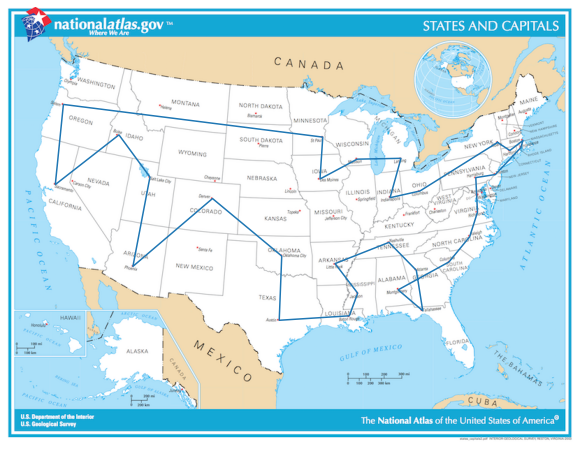

In [62]:
results = AntColonyRunner(cities, distance_power=1, verbose=True, plot=True)

**Solving With Wild Ants**

{'path_cost': 6351, 'ants_used': 1, 'epoch': 6169, 'round_trips': 1, 'clock': 0}
{'path_cost': 6144, 'ants_used': 65, 'epoch': 12763, 'round_trips': 2, 'clock': 0}
{'path_cost': 6035, 'ants_used': 68, 'epoch': 13277, 'round_trips': 2, 'clock': 0}
{'path_cost': 5938, 'ants_used': 129, 'epoch': 19026, 'round_trips': 3, 'clock': 0}
{'path_cost': 5709, 'ants_used': 259, 'epoch': 34245, 'round_trips': 5, 'clock': 0}
{'path_cost': 5601, 'ants_used': 336, 'epoch': 42647, 'round_trips': 6, 'clock': 0}
{'path_cost': 5418, 'ants_used': 388, 'epoch': 47871, 'round_trips': 7, 'clock': 0}
{'path_cost': 4990, 'ants_used': 533, 'epoch': 62698, 'round_trips': 9, 'clock': 0}
{'path_cost': 4891, 'ants_used': 650, 'epoch': 73357, 'round_trips': 11, 'clock': 1}
{'path_cost': 4633, 'ants_used': 830, 'epoch': 90325, 'round_trips': 14, 'clock': 1}
{'path_cost': 4601, 'ants_used': 971, 'epoch': 102861, 'round_trips': 15, 'clock': 1}
{'path_cost': 4596, 'ants_used': 1048, 'epoch': 109281, 'round_trips': 17, 'c

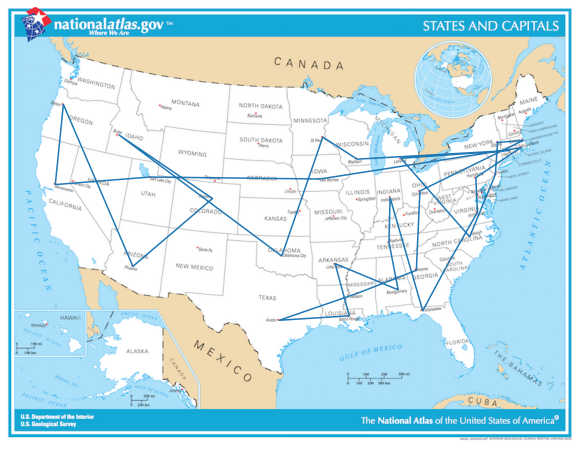

In [63]:
results = AntColonyRunner(cities, distance_power=0, stop_factor=1.25, verbose=True, plot=True)

{'path_cost': 6869, 'ants_used': 1, 'epoch': 6660, 'round_trips': 1, 'clock': 0}
{'path_cost': 6232, 'ants_used': 65, 'epoch': 13488, 'round_trips': 2, 'clock': 0}
{'path_cost': 6064, 'ants_used': 322, 'epoch': 42934, 'round_trips': 6, 'clock': 0}
{'path_cost': 5936, 'ants_used': 385, 'epoch': 49575, 'round_trips': 7, 'clock': 0}
{'path_cost': 5562, 'ants_used': 589, 'epoch': 71748, 'round_trips': 10, 'clock': 0}
{'path_cost': 5305, 'ants_used': 639, 'epoch': 76476, 'round_trips': 11, 'clock': 1}
{'path_cost': 4888, 'ants_used': 1335, 'epoch': 147058, 'round_trips': 22, 'clock': 2}
{'path_cost': 4642, 'ants_used': 1987, 'epoch': 209938, 'round_trips': 32, 'clock': 2}
{'path_cost': 4518, 'ants_used': 2837, 'epoch': 287502, 'round_trips': 45, 'clock': 4}
{'path_cost': 4392, 'ants_used': 2964, 'epoch': 298310, 'round_trips': 47, 'clock': 4}
{'path_cost': 4344, 'ants_used': 3416, 'epoch': 335969, 'round_trips': 54, 'clock': 4}
{'path_cost': 4291, 'ants_used': 3456, 'epoch': 338975, 'round_

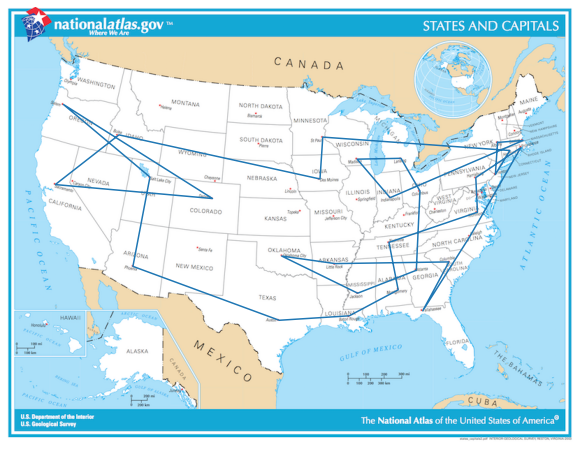

In [64]:
results = AntColonyRunner(cities, distance_power=0, min_time=30, verbose=True, plot=True)

**Statistical Random Variation**

In [65]:
results_converged = [ AntColonyRunner(cities) for i in range(10) ]

N=30  |  7074 -> 2575 |    1s | ants:  1042 | trips:   17 | 
N=30  |  7074 -> 2230 |    1s | ants:  1247 | trips:   20 | 
N=30  |  7074 -> 2362 |    3s | ants:  2804 | trips:   45 | 
N=30  |  7074 -> 2347 |    1s | ants:  1154 | trips:   19 | 
N=30  |  7074 -> 2332 |    2s | ants:  2146 | trips:   35 | 
N=30  |  7074 -> 2369 |    1s | ants:   891 | trips:   15 | 
N=30  |  7074 -> 2374 |    3s | ants:  2637 | trips:   42 | 
N=30  |  7074 -> 2295 |    2s | ants:  1955 | trips:   32 | 
N=30  |  7074 -> 2315 |    2s | ants:  2418 | trips:   39 | 
N=30  |  7074 -> 2321 |    2s | ants:  1696 | trips:   27 | 


In [66]:
results_timed = [ AntColonyRunner(cities, time=10) for i in range(10) ]

N=30  |  7074 -> 2292 |   10s | ants: 10931 | trips:  172 | time=10
N=30  |  7074 -> 2263 |   10s | ants: 10638 | trips:  168 | time=10
N=30  |  7074 -> 2242 |   10s | ants: 11082 | trips:  174 | time=10
N=30  |  7074 -> 2187 |   10s | ants: 10499 | trips:  166 | time=10
N=30  |  7074 -> 2198 |   10s | ants: 10949 | trips:  173 | time=10
N=30  |  7074 -> 2355 |   10s | ants: 10755 | trips:  169 | time=10
N=30  |  7074 -> 2232 |   10s | ants: 10621 | trips:  169 | time=10
N=30  |  7074 -> 2252 |   10s | ants: 10811 | trips:  171 | time=10
N=30  |  7074 -> 2294 |   10s | ants: 10693 | trips:  168 | time=10
N=30  |  7074 -> 2199 |   10s | ants: 10829 | trips:  172 | time=10


In [67]:
import pandas as pd
results_converged_stats = pd.Series([ path_distance(path) for path in results_converged ]).describe()
results_timed_stats     = pd.Series([ path_distance(path) for path in results_timed     ]).describe()
pd.DataFrame({
    "results_converged": results_converged_stats,
    "results_timed":     results_timed_stats,
    "difference":        results_converged_stats - results_timed_stats,
}).T.round(1)

count    mean   std     min     25%     50%     75%     max
results_converged   10.0  2352.0  89.1  2230.0  2316.5  2339.5  2367.2  2575.0
results_timed       10.0  2251.4  52.2  2187.0  2207.2  2247.0  2284.8  2355.0
difference           0.0   100.6  36.9    43.0   109.2    92.5    82.5   220.0

In [68]:
for ant_count in range(0,16+1):
    AntColonyRunner(cities, ant_count=2**ant_count, time=60)

N=30  |  7074 -> 2235 |   60s | ants:  3581 | trips: 3581 | ant_count=1 time=60
N=30  |  7074 -> 2901 |   60s | ants:  6511 | trips: 3256 | ant_count=2 time=60
N=30  |  7074 -> 2226 |   60s | ants: 15383 | trips: 3847 | ant_count=4 time=60
N=30  |  7074 -> 2480 |   60s | ants: 22512 | trips: 2817 | ant_count=8 time=60
N=30  |  7074 -> 2407 |   60s | ants: 37956 | trips: 2378 | ant_count=16 time=60
N=30  |  7074 -> 2232 |   60s | ants: 53390 | trips: 1670 | ant_count=32 time=60
N=30  |  7074 -> 2179 |   60s | ants: 66537 | trips: 1044 | ant_count=64 time=60
N=30  |  7074 -> 2349 |   60s | ants: 76481 | trips:  601 | ant_count=128 time=60
N=30  |  7074 -> 2240 |   60s | ants: 88534 | trips:  347 | ant_count=256 time=60
N=30  |  7074 -> 2191 |   60s | ants: 93321 | trips:  183 | ant_count=512 time=60
N=30  |  7074 -> 2201 |   60s | ants: 95534 | trips:   95 | ant_count=1024 time=60
N=30  |  7074 -> 2170 |   60s | ants: 96646 | trips:   49 | ant_count=2048 time=60
N=30  |  7074 -> 2217 |  

In [69]:
for N in range(8,30+1):
    best = { "ant_count": 0, "min_ants": 0, "path": None, "count": 0 }
    for ant_count in [8,16,32,64,128,256,512,1024,2048]:
        for min_ants in [64,128,256,512,1024,2048,4096,8192]:
            result = AntColonySolver(ant_count=ant_count, min_ants=min_ants, cost_fn=distance).solve(cities[:N])
            if not best['path'] or best['path'] > path_distance(result):
                best = { "ant_count": ant_count, "min_ants": min_ants, "path": path_distance(result), "count": best['count']+1 }
                continue
            if best['count'] >= 3: 
                best['count'] = 0
                break
    AntColonyRunner(cities[:N], ant_count=best['ant_count'], min_ants=best['min_ants'])

N=8   |  1969 -> 1426 |    0s | ants:    69 | trips:   10 | ant_count=8 min_ants=64
N=9   |  2552 -> 1436 |    1s | ants:   615 | trips:   79 | ant_count=8 min_ants=128
N=10  |  2552 -> 1450 |    0s | ants:   128 | trips:   17 | ant_count=8 min_ants=128
N=11  |  2575 -> 1445 |    1s | ants:   512 | trips:   65 | ant_count=8 min_ants=512
N=12  |  2599 -> 1459 |    1s | ants:  1024 | trips:   65 | ant_count=16 min_ants=1024
N=13  |  2935 -> 1526 |    0s | ants:   213 | trips:   27 | ant_count=8 min_ants=128
N=14  |  3201 -> 1501 |    1s | ants:   512 | trips:   65 | ant_count=8 min_ants=512
N=15  |  3250 -> 1543 |    1s | ants:   677 | trips:   43 | ant_count=16 min_ants=256
N=16  |  3578 -> 1600 |    1s | ants:   560 | trips:   36 | ant_count=16 min_ants=512
N=17  |  3643 -> 1638 |    0s | ants:   744 | trips:   12 | ant_count=64 min_ants=256
N=18  |  3891 -> 1694 |    1s | ants:  1024 | trips:   65 | ant_count=16 min_ants=1024
N=19  |  3917 -> 1703 |    4s | ants:  8192 | trips:   65 |

In [70]:
for ant_speed in list(range(0,10+1)):
    result = AntColonyRunner(cities, ant_speed=2**ant_speed, time=10)
result = AntColonyRunner(cities, ant_speed=0, time=10)    

N=30  |  7074 -> 2204 |   10s | ants: 10662 | trips:  168 | ant_speed=1 time=10
N=30  |  7074 -> 2232 |   10s | ants: 13106 | trips:  207 | ant_speed=2 time=10
N=30  |  7074 -> 2348 |   10s | ants: 14785 | trips:  233 | ant_speed=4 time=10
N=30  |  7074 -> 2269 |   10s | ants: 15747 | trips:  248 | ant_speed=8 time=10
N=30  |  7074 -> 2253 |   10s | ants: 16929 | trips:  265 | ant_speed=16 time=10
N=30  |  7074 -> 2328 |   10s | ants: 17237 | trips:  271 | ant_speed=32 time=10
N=30  |  7074 -> 2483 |   10s | ants: 17777 | trips:  279 | ant_speed=64 time=10
N=30  |  7074 -> 2203 |   10s | ants: 17853 | trips:  279 | ant_speed=128 time=10
N=30  |  7074 -> 2188 |   10s | ants: 17830 | trips:  279 | ant_speed=256 time=10
N=30  |  7074 -> 2266 |   10s | ants: 18551 | trips:  290 | ant_speed=512 time=10
N=30  |  7074 -> 2310 |   10s | ants: 18560 | trips:  290 | ant_speed=1024 time=10
N=30  |  7074 -> 2213 |   10s | ants: 17652 | trips:  278 | ant_speed=0 time=10


In [71]:
for distance_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 5.0, 10.0]:
    result = AntColonyRunner(cities, distance_power=distance_power, timeout=60)

N=30  |  7074 -> 8304 |    1s | ants:   577 | trips:   10 | distance_power=-2.0 timeout=60
N=30  |  7074 -> 7618 |    1s | ants:   577 | trips:   10 | distance_power=-1.0 timeout=60
N=30  |  7074 -> 3651 |    4s | ants:  3250 | trips:   52 | distance_power=0.0 timeout=60
N=30  |  7074 -> 2539 |    3s | ants:  2786 | trips:   44 | distance_power=0.5 timeout=60
N=30  |  7074 -> 2279 |    5s | ants:  5211 | trips:   82 | distance_power=1.0 timeout=60
N=30  |  7074 -> 2206 |   10s | ants: 10100 | trips:  160 | distance_power=1.25 timeout=60
N=30  |  7074 -> 2279 |    2s | ants:  2229 | trips:   36 | distance_power=1.5 timeout=60
N=30  |  7074 -> 2317 |    2s | ants:  1654 | trips:   27 | distance_power=1.75 timeout=60
N=30  |  7074 -> 2225 |    1s | ants:  1026 | trips:   17 | distance_power=2.0 timeout=60
N=30  |  7074 -> 2299 |    1s | ants:   625 | trips:   10 | distance_power=3.0 timeout=60
N=30  |  7074 -> 2247 |    1s | ants:   727 | trips:   12 | distance_power=5.0 timeout=60
N=30  

In [72]:
for distance_power in [0,1,2]:
    for pheromone_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, pheromone_power=pheromone_power, time=0)
    print()

N=30  |  7074 -> 5840 |    4s | ants:  2174 | trips:   35 | distance_power=0 pheromone_power=-2.0 time=0
N=30  |  7074 -> 5623 |    1s | ants:   674 | trips:   11 | distance_power=0 pheromone_power=-1.0 time=0
N=30  |  7074 -> 5596 |    2s | ants:  1262 | trips:   21 | distance_power=0 pheromone_power=0.0 time=0
N=30  |  7074 -> 5213 |    1s | ants:   567 | trips:   10 | distance_power=0 pheromone_power=0.5 time=0
N=30  |  7074 -> 5645 |    1s | ants:   570 | trips:   10 | distance_power=0 pheromone_power=1.0 time=0
N=30  |  7074 -> 3776 |    6s | ants:  4490 | trips:   72 | distance_power=0 pheromone_power=1.25 time=0
N=30  |  7074 -> 4524 |    5s | ants:  3250 | trips:   52 | distance_power=0 pheromone_power=1.5 time=0
N=30  |  7074 -> 3798 |    7s | ants:  5721 | trips:   91 | distance_power=0 pheromone_power=1.75 time=0
N=30  |  7074 -> 4600 |    4s | ants:  3202 | trips:   51 | distance_power=0 pheromone_power=2.0 time=0
N=30  |  7074 -> 4910 |    1s | ants:   686 | trips:   11 | 

In [73]:
for distance_power in [0,1,2]:
    for pheromone_power in [1.0, 1.1, 1.2, 1.3, 1.4]:
        result = AntColonyRunner(cities, distance_power=distance_power, pheromone_power=pheromone_power, time=0)
    print()

N=30  |  7074 -> 3368 |   19s | ants: 16245 | trips:  257 | distance_power=0 pheromone_power=1.0 time=0
N=30  |  7074 -> 4559 |    2s | ants:  1330 | trips:   22 | distance_power=0 pheromone_power=1.1 time=0
N=30  |  7074 -> 3703 |   11s | ants:  8634 | trips:  137 | distance_power=0 pheromone_power=1.2 time=0
N=30  |  7074 -> 4418 |    1s | ants:   651 | trips:   11 | distance_power=0 pheromone_power=1.3 time=0
N=30  |  7074 -> 5761 |    1s | ants:   706 | trips:   12 | distance_power=0 pheromone_power=1.4 time=0

N=30  |  7074 -> 2375 |    2s | ants:  2223 | trips:   36 | distance_power=1 pheromone_power=1.0 time=0
N=30  |  7074 -> 2223 |    2s | ants:  2291 | trips:   37 | distance_power=1 pheromone_power=1.1 time=0
N=30  |  7074 -> 2342 |   10s | ants: 10014 | trips:  159 | distance_power=1 pheromone_power=1.2 time=0
N=30  |  7074 -> 2191 |    2s | ants:  2317 | trips:   38 | distance_power=1 pheromone_power=1.3 time=0
N=30  |  7074 -> 2213 |    2s | ants:  1754 | trips:   28 | dis

In [74]:
for pheromone_power in [1.0, 1.25]:
    for distance_power in [0,1,2]:
        for decay_power in [-1.0, 0.0, 1.0, 1.25, 1.5, 2.0, 3.0]:
            result = AntColonyRunner(cities, pheromone_power=pheromone_power, distance_power=distance_power, decay_power=decay_power, time=15)
        print()
    print()

N=30  |  7074 -> 3337 |   15s | ants: 11787 | trips:  187 | pheromone_power=1.0 distance_power=0 decay_power=-1.0 time=15
N=30  |  7074 -> 3105 |   15s | ants: 12197 | trips:  194 | pheromone_power=1.0 distance_power=0 decay_power=0.0 time=15
N=30  |  7074 -> 4518 |   15s | ants:  9203 | trips:  147 | pheromone_power=1.0 distance_power=0 decay_power=1.0 time=15
N=30  |  7074 -> 2796 |   15s | ants:  9507 | trips:  152 | pheromone_power=1.0 distance_power=0 decay_power=1.25 time=15
N=30  |  7074 -> 4803 |   15s | ants:  9123 | trips:  146 | pheromone_power=1.0 distance_power=0 decay_power=1.5 time=15
N=30  |  7074 -> 3236 |   15s | ants: 10816 | trips:  172 | pheromone_power=1.0 distance_power=0 decay_power=2.0 time=15
N=30  |  7074 -> 4856 |   15s | ants:  9108 | trips:  145 | pheromone_power=1.0 distance_power=0 decay_power=3.0 time=15

N=30  |  7074 -> 2252 |   15s | ants: 14050 | trips:  222 | pheromone_power=1.0 distance_power=1 decay_power=-1.0 time=15
N=30  |  7074 -> 2306 |   15

In [75]:
for distance_power in [0,1,2]:
    for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, decay_power=decay_power, time=0)
    print()

N=30  |  7074 -> 4820 |    1s | ants:   547 | trips:   10 | distance_power=0 decay_power=-2.0 time=0
N=30  |  7074 -> 3248 |   60s | ants: 46683 | trips:  733 | distance_power=0 decay_power=-1.0 time=0
N=30  |  7074 -> 4529 |    2s | ants:  1195 | trips:   20 | distance_power=0 decay_power=0.0 time=0
N=30  |  7074 -> 5471 |    1s | ants:   572 | trips:   10 | distance_power=0 decay_power=0.5 time=0
N=30  |  7074 -> 3143 |   12s | ants:  9705 | trips:  153 | distance_power=0 decay_power=1.0 time=0
N=30  |  7074 -> 3744 |    7s | ants:  5500 | trips:   87 | distance_power=0 decay_power=1.25 time=0
N=30  |  7074 -> 3465 |    7s | ants:  4764 | trips:   76 | distance_power=0 decay_power=1.5 time=0
N=30  |  7074 -> 3501 |    6s | ants:  4527 | trips:   73 | distance_power=0 decay_power=2.0 time=0
N=30  |  7074 -> 5100 |    1s | ants:   724 | trips:   12 | distance_power=0 decay_power=3.0 time=0
N=30  |  7074 -> 3778 |    4s | ants:  2849 | trips:   46 | distance_power=0 decay_power=5.0 time

In [76]:
for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
    result = AntColonyRunner(cities, decay_power=decay_power, timeout=60)
    print()

N=30  |  7074 -> 2248 |    1s | ants:  1216 | trips:   20 | decay_power=-2.0 timeout=60

N=30  |  7074 -> 2222 |    1s | ants:  1132 | trips:   18 | decay_power=-1.0 timeout=60

N=30  |  7074 -> 2310 |    3s | ants:  2871 | trips:   46 | decay_power=0.0 timeout=60

N=30  |  7074 -> 2481 |    3s | ants:  2399 | trips:   39 | decay_power=0.5 timeout=60

N=30  |  7074 -> 2240 |    3s | ants:  2919 | trips:   47 | decay_power=1.0 timeout=60

N=30  |  7074 -> 2222 |    4s | ants:  3726 | trips:   59 | decay_power=1.25 timeout=60

N=30  |  7074 -> 2295 |    2s | ants:  1364 | trips:   22 | decay_power=1.5 timeout=60

N=30  |  7074 -> 2289 |    1s | ants:   576 | trips:   10 | decay_power=2.0 timeout=60

N=30  |  7074 -> 2237 |    1s | ants:  1186 | trips:   19 | decay_power=3.0 timeout=60

N=30  |  7074 -> 2221 |    1s | ants:   892 | trips:   15 | decay_power=5.0 timeout=60

N=30  |  7074 -> 2200 |    2s | ants:  1329 | trips:   22 | decay_power=10.0 timeout=60



In [77]:
for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
    for reward_power in range(-5,5+1):
        result = AntColonyRunner(cities, decay_power=decay_power, reward_power=reward_power, time=15)
    print() 

N=30  |  7074 -> 2332 |   15s | ants: 13704 | trips:  216 | decay_power=-2.0 reward_power=-5 time=15
N=30  |  7074 -> 2406 |   15s | ants: 13568 | trips:  216 | decay_power=-2.0 reward_power=-4 time=15
N=30  |  7074 -> 2274 |   15s | ants: 13900 | trips:  218 | decay_power=-2.0 reward_power=-3 time=15
N=30  |  7074 -> 2306 |   15s | ants: 13752 | trips:  217 | decay_power=-2.0 reward_power=-2 time=15
N=30  |  7074 -> 2365 |   15s | ants: 14192 | trips:  223 | decay_power=-2.0 reward_power=-1 time=15
N=30  |  7074 -> 2275 |   15s | ants: 13793 | trips:  218 | decay_power=-2.0 reward_power=0 time=15
N=30  |  7074 -> 2364 |   15s | ants: 13429 | trips:  212 | decay_power=-2.0 reward_power=1 time=15
N=30  |  7074 -> 2277 |   15s | ants: 14256 | trips:  226 | decay_power=-2.0 reward_power=2 time=15
N=30  |  7074 -> 2307 |   15s | ants: 13687 | trips:  216 | decay_power=-2.0 reward_power=3 time=15
N=30  |  7074 -> 2353 |   15s | ants: 14151 | trips:  224 | decay_power=-2.0 reward_power=4 tim

In [78]:
for distance_power in [0,1,2]:
    for best_path_smell in [0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, best_path_smell=best_path_smell, time=15)
    print()

N=30  |  7074 -> 5893 |   15s | ants:  9371 | trips:  149 | distance_power=0 best_path_smell=0.0 time=15
N=30  |  7074 -> 5400 |   15s | ants:  9259 | trips:  147 | distance_power=0 best_path_smell=0.5 time=15
N=30  |  7074 -> 5257 |   15s | ants:  9722 | trips:  155 | distance_power=0 best_path_smell=1.0 time=15
N=30  |  7074 -> 4067 |   15s | ants: 10150 | trips:  161 | distance_power=0 best_path_smell=1.25 time=15
N=30  |  7074 -> 3405 |   15s | ants: 11561 | trips:  184 | distance_power=0 best_path_smell=1.5 time=15
N=30  |  7074 -> 3303 |   15s | ants: 12952 | trips:  205 | distance_power=0 best_path_smell=2.0 time=15
N=30  |  7074 -> 3715 |   15s | ants: 12851 | trips:  203 | distance_power=0 best_path_smell=3.0 time=15
N=30  |  7074 -> 4121 |   15s | ants: 12107 | trips:  191 | distance_power=0 best_path_smell=5.0 time=15
N=30  |  7074 -> 4051 |   15s | ants: 13065 | trips:  205 | distance_power=0 best_path_smell=10.0 time=15

N=30  |  7074 -> 3259 |   15s | ants: 12046 | trips:

In [79]:
for distance_power in [0,1,2]:
    for best_path_smell in [0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, best_path_smell=best_path_smell, min_round_trips=20, time=0)
    print()
    

N=30  |  7074 -> 5324 |    2s | ants:  1216 | trips:   20 | distance_power=0 best_path_smell=0.0 min_round_trips=20 time=0
N=30  |  7074 -> 5739 |    2s | ants:  1434 | trips:   23 | distance_power=0 best_path_smell=0.5 min_round_trips=20 time=0
N=30  |  7074 -> 5368 |    2s | ants:  1194 | trips:   20 | distance_power=0 best_path_smell=1.0 min_round_trips=20 time=0
N=30  |  7074 -> 5823 |    2s | ants:  1201 | trips:   20 | distance_power=0 best_path_smell=1.25 min_round_trips=20 time=0
N=30  |  7074 -> 3348 |   13s | ants: 10410 | trips:  166 | distance_power=0 best_path_smell=1.5 min_round_trips=20 time=0
N=30  |  7074 -> 4045 |    3s | ants:  2577 | trips:   41 | distance_power=0 best_path_smell=2.0 min_round_trips=20 time=0
N=30  |  7074 -> 4390 |   10s | ants:  7823 | trips:  123 | distance_power=0 best_path_smell=3.0 min_round_trips=20 time=0
N=30  |  7074 -> 3968 |    3s | ants:  2826 | trips:   45 | distance_power=0 best_path_smell=5.0 min_round_trips=20 time=0
N=30  |  7074 -

In [80]:
# Start Smell
for distance_power in [0, 1, 2]:
    for start_smell in list(range(0,8)):
        result = AntColonyRunner(cities, distance_power=distance_power, start_smell=10**start_smell, time=15)
    result = AntColonyRunner(cities, distance_power=distance_power, start_smell=0, time=15)
    print()

N=30  |  7074 -> 3705 |   15s | ants: 12628 | trips:  199 | distance_power=0 start_smell=1 time=15
N=30  |  7074 -> 3498 |   15s | ants: 12797 | trips:  202 | distance_power=0 start_smell=10 time=15
N=30  |  7074 -> 3597 |   15s | ants: 12636 | trips:  200 | distance_power=0 start_smell=100 time=15
N=30  |  7074 -> 3425 |   15s | ants: 12727 | trips:  202 | distance_power=0 start_smell=1000 time=15
N=30  |  7074 -> 3101 |   15s | ants: 12698 | trips:  202 | distance_power=0 start_smell=10000 time=15
N=30  |  7074 -> 3371 |   15s | ants: 13207 | trips:  208 | distance_power=0 start_smell=100000 time=15
N=30  |  7074 -> 3358 |   15s | ants: 13532 | trips:  214 | distance_power=0 start_smell=1000000 time=15
N=30  |  7074 -> 3659 |   15s | ants: 13111 | trips:  207 | distance_power=0 start_smell=10000000 time=15
N=30  |  7074 -> 4109 |   15s | ants: 12305 | trips:  194 | distance_power=0 start_smell=0 time=15

N=30  |  7074 -> 2267 |   15s | ants: 16259 | trips:  257 | distance_power=1 sta

In [81]:
# Stop Factor
for distance_power in [0, 1, 2]:
    for stop_factor in [1.25, 1.5, 1.75, 2, 5]:
        result = AntColonyRunner(cities, distance_power=distance_power, stop_factor=stop_factor)
    print()

N=30  |  7074 -> 4495 |    1s | ants:   676 | trips:   11 | distance_power=0 stop_factor=1.25
N=30  |  7074 -> 5172 |    1s | ants:   691 | trips:   12 | distance_power=0 stop_factor=1.5
N=30  |  7074 -> 3737 |    3s | ants:  2092 | trips:   34 | distance_power=0 stop_factor=1.75
N=30  |  7074 -> 3323 |    9s | ants:  7609 | trips:  121 | distance_power=0 stop_factor=2
N=30  |  7074 -> 3068 | 1882s | ants: 1718610 | trips: 26876 | distance_power=0 stop_factor=5

N=30  |  7074 -> 2257 |    1s | ants:   673 | trips:   11 | distance_power=1 stop_factor=1.25
N=30  |  7074 -> 2405 |    1s | ants:   987 | trips:   17 | distance_power=1 stop_factor=1.5
N=30  |  7074 -> 2452 |    4s | ants:  4005 | trips:   64 | distance_power=1 stop_factor=1.75
N=30  |  7074 -> 2227 |    1s | ants:  1368 | trips:   22 | distance_power=1 stop_factor=2
N=30  |  7074 -> 2199 |    6s | ants:  5945 | trips:   94 | distance_power=1 stop_factor=5

N=30  |  7074 -> 2350 |    1s | ants:   569 | trips:   11 | distance_

[('pbiufcxolg', (402.6, 463.8)), ('gbkxwzfjfw', (123.3, 323.8)), ('mfmqvjuanu', (197.5, 314.8)), ('ksyduwqimq', (202.3, 376.3)), ('aqosiixbdb', (483.9, 405.2))]


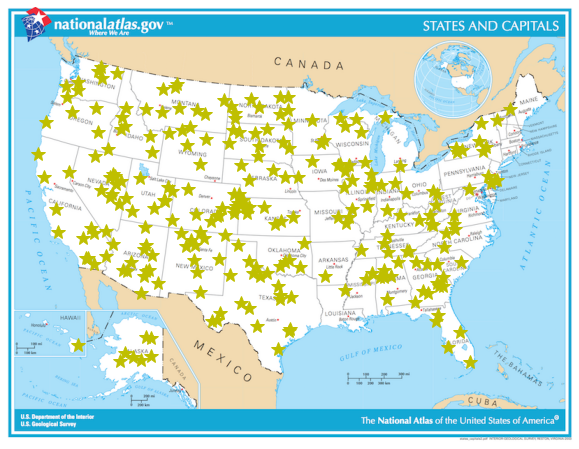

In [82]:
# NP Hard Scalability 
import string
def create_cities(size, max_x=1000, max_y=1000, image=None, color=1, border=30):
    if (image is not None):
        max_x = image.shape[0] - 1 - border*2
        max_y = image.shape[1] - 1 - border*2
    cities = {}
    while len(cities) <= size:
        name = ''.join(random.choices(string.ascii_lowercase, k=10))
        x = round( border + random.random() * max_x,  1)
        y = round( border + random.random() * max_y,  1)
        if (image is not None) and not all( image[int(x)][int(y)] == color ): continue
        cities[(int(x),int(y))] = ( name, (y,x) )               
    return list(cities.values())

np_hard = create_cities(256, image=united_states_map)
print(np_hard[:5])
show_cities(np_hard)

N=8   |  1767 -> 1348 |    0s | ants:   575 | trips:   10 | N=8 timeout=3600
N=16  |  3248 -> 1588 |    1s | ants:  2892 | trips:   47 | N=16 timeout=3600
N=32  |  8208 -> 2469 |    3s | ants:  3064 | trips:   49 | N=32 timeout=3600
N=64  | 17200 -> 3399 |   23s | ants:  7777 | trips:  124 | N=64 timeout=3600
N=128 | 32610 -> 5339 |   70s | ants:  6654 | trips:  106 | N=128 timeout=3600
N=256 | 64958 -> 7399 |  252s | ants:  6161 | trips:   97 | N=256 timeout=3600



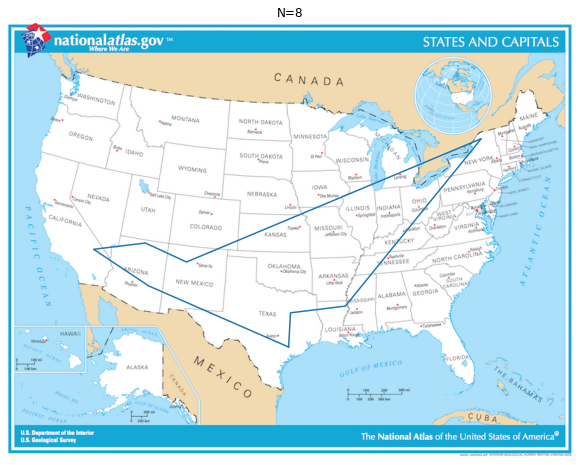

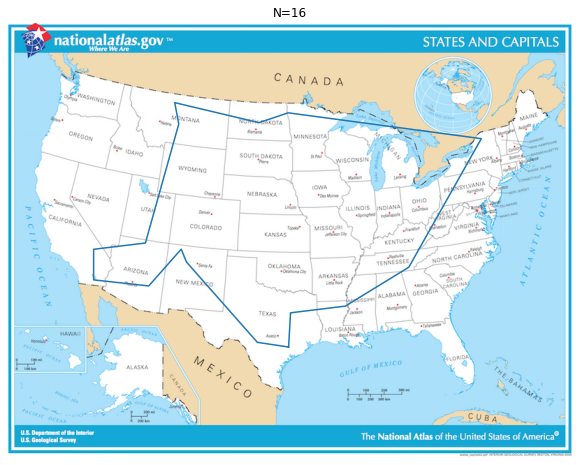

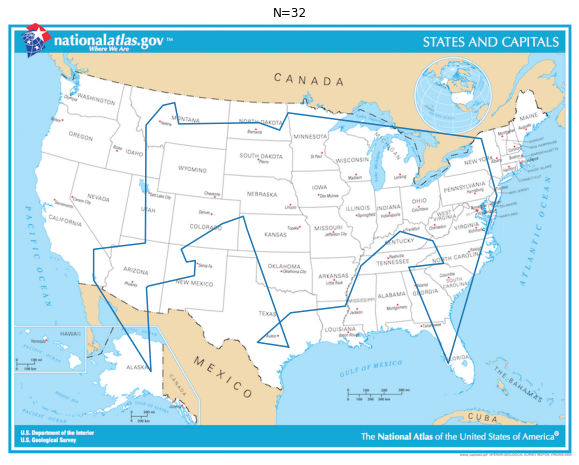

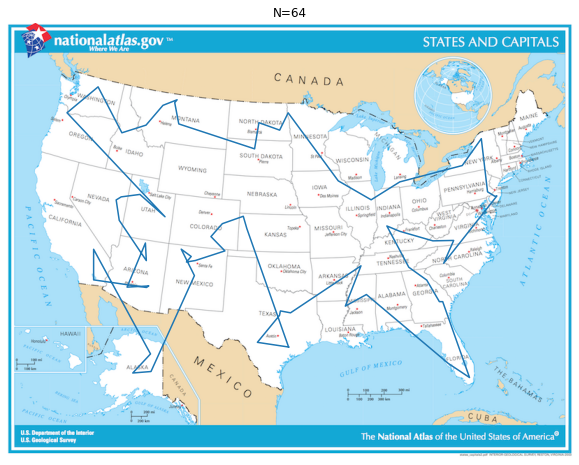

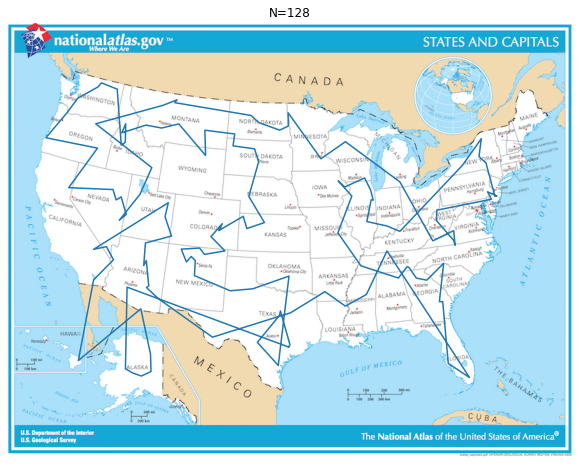

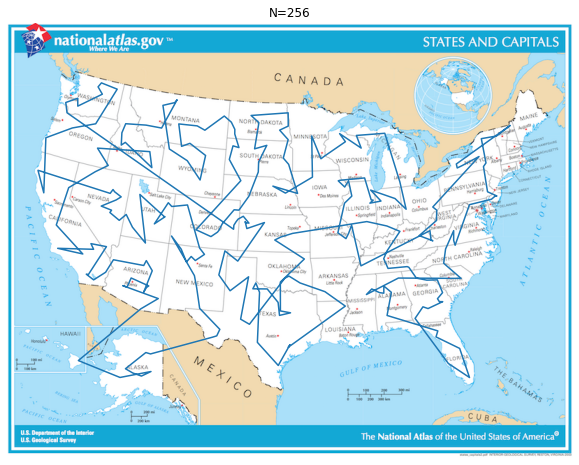

In [83]:
for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')        
    show_path(result)    
print()

N=8   |  1767 -> 1348 |    0s | ants:   575 | trips:   10 | N=8 max_ants=64 timeout=3600
N=16  |  3248 -> 1597 |    0s | ants:   547 | trips:   10 | N=16 max_ants=256 timeout=3600
N=32  |  8208 -> 2622 |    1s | ants:   622 | trips:   10 | N=32 max_ants=1024 timeout=3600
N=64  | 17200 -> 3482 |   12s | ants:  3953 | trips:   63 | N=64 max_ants=4096 timeout=3600
N=128 | 32610 -> 5105 |   98s | ants:  9476 | trips:  149 | N=128 max_ants=16384 timeout=3600
N=256 | 64958 -> 7666 |  212s | ants:  5284 | trips:   84 | N=256 max_ants=65536 timeout=3600



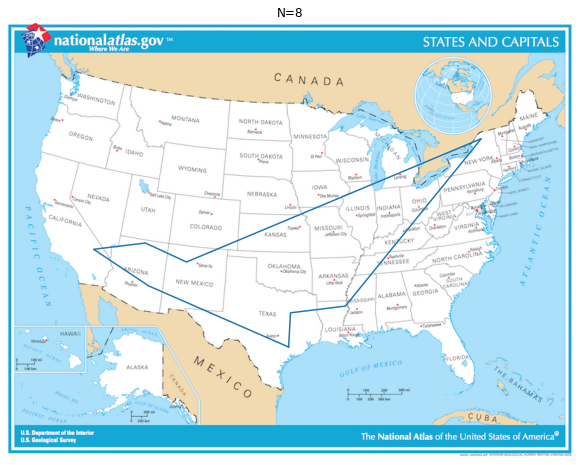

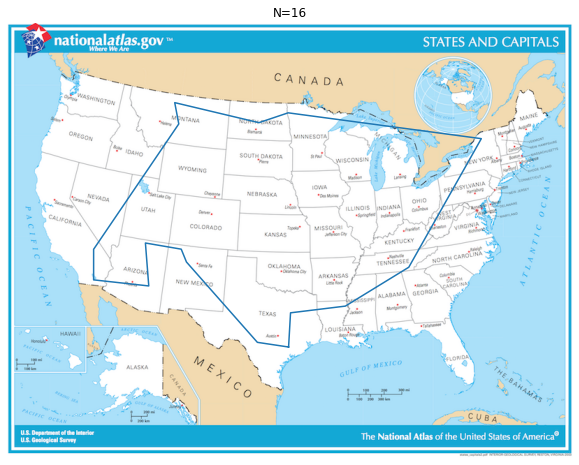

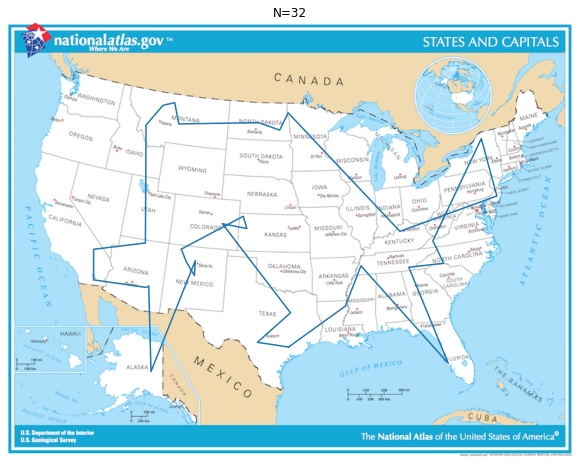

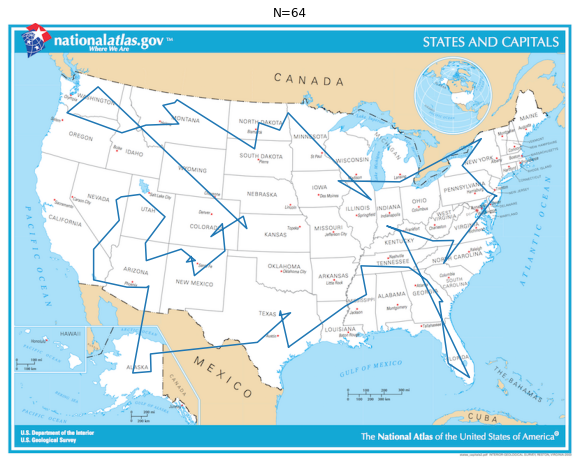

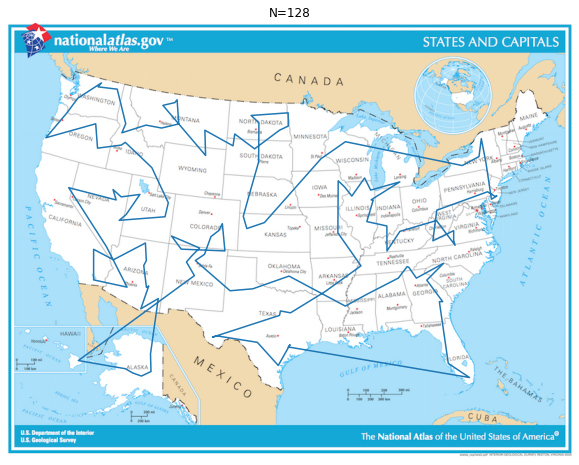

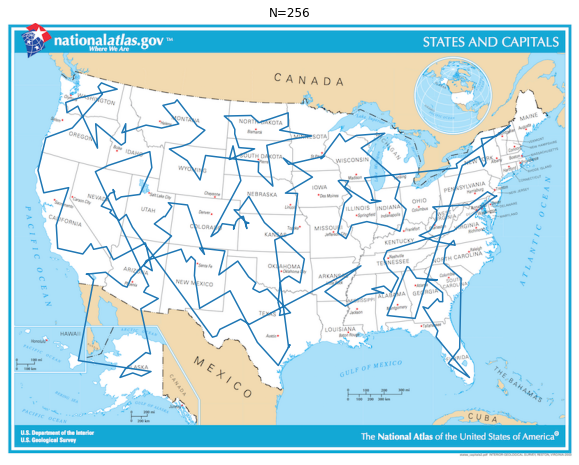

In [84]:
for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, max_ants=N**2, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')    
    show_path(result)        
print()

N=8   |  1767 -> 1348 |    0s | ants:   577 | trips:   10 | N=8 distance_power=10 max_ants=64 timeout=3600
N=16  |  3248 -> 1636 |    0s | ants:   577 | trips:   10 | N=16 distance_power=10 max_ants=256 timeout=3600
N=32  |  8208 -> 2383 |    1s | ants:  1022 | trips:   16 | N=32 distance_power=10 max_ants=1024 timeout=3600
N=64  | 17200 -> 3268 |    2s | ants:   638 | trips:   10 | N=64 distance_power=10 max_ants=4096 timeout=3600
N=128 | 32610 -> 4808 |   12s | ants:  1280 | trips:   20 | N=128 distance_power=10 max_ants=16384 timeout=3600
N=256 | 64958 -> 6528 |   32s | ants:   838 | trips:   14 | N=256 distance_power=10 max_ants=65536 timeout=3600



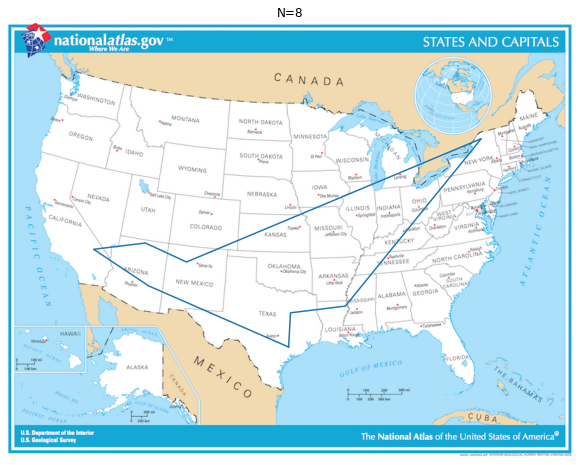

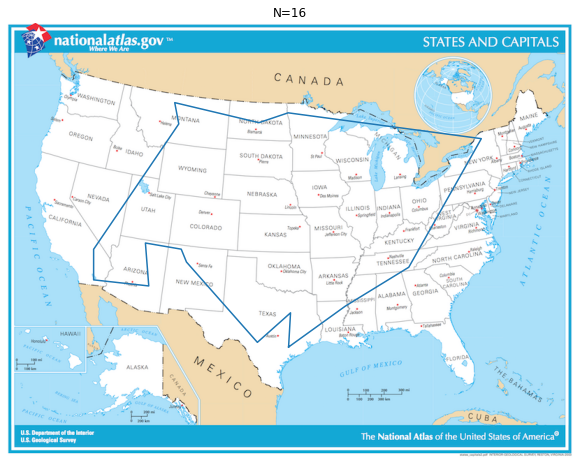

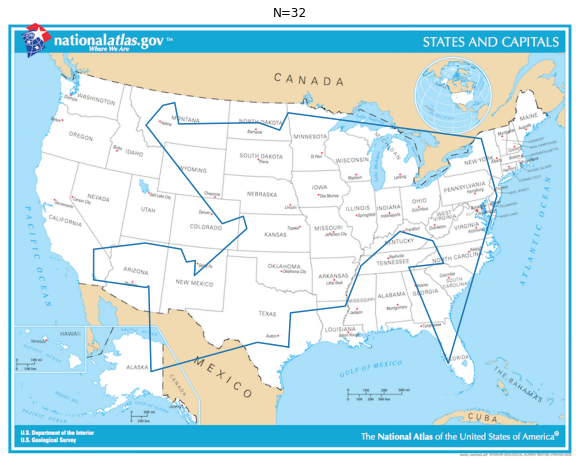

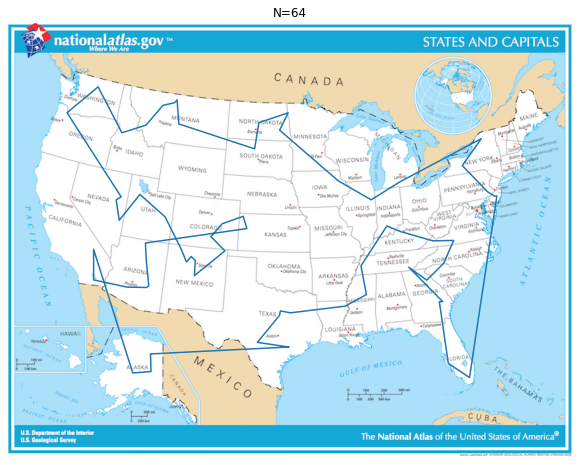

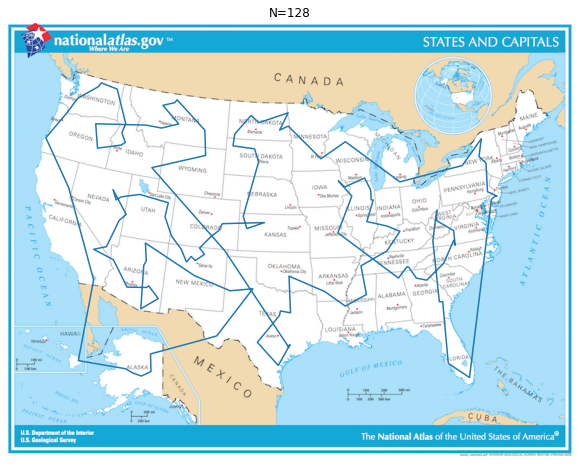

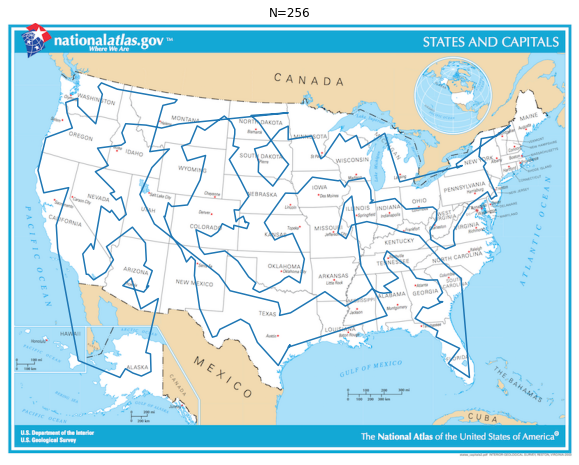

In [85]:
for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, distance_power=10, max_ants=N**2, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')
    show_path(result)            
print()


N=4   |   853 ->  837 |    0s | ants:   534 | trips:   10 | timeout=3600
N=8   |  1969 -> 1426 |    0s | ants:   511 | trips:   10 | timeout=3600
N=16  |  3578 -> 1609 |    1s | ants:  1361 | trips:   23 | timeout=3600
N=30  |  7074 -> 2278 |    1s | ants:  1257 | trips:   20 | timeout=3600
N=30  |  7074 -> 2267 |    3s | ants:  3289 | trips:   53 | timeout=3600
N=30  |  7074 -> 2562 |    3s | ants:  2656 | trips:   43 | timeout=3600
N=30  |  7074 -> 2283 |    2s | ants:  2065 | trips:   33 | timeout=3600
N=30  |  7074 -> 2211 |    3s | ants:  3424 | trips:   55 | timeout=3600


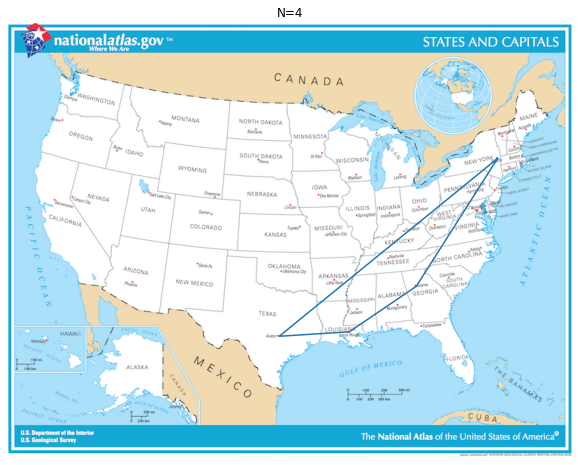

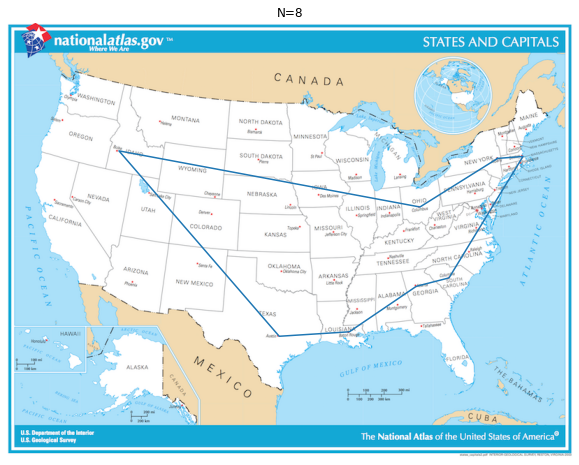

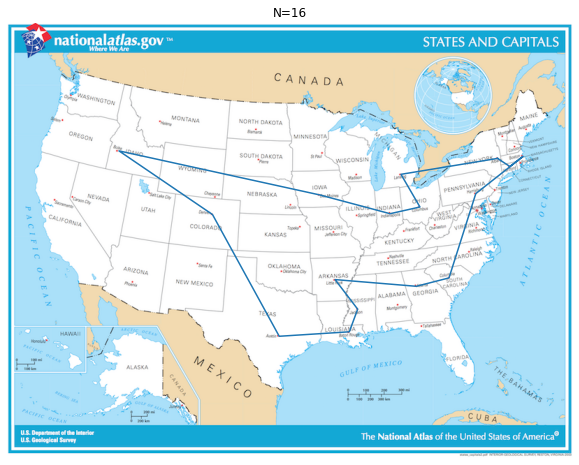

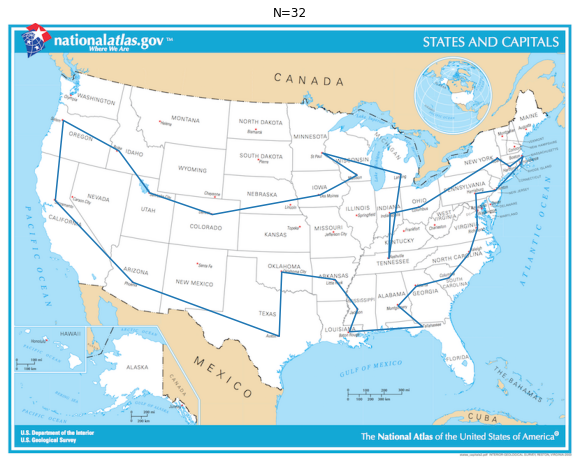

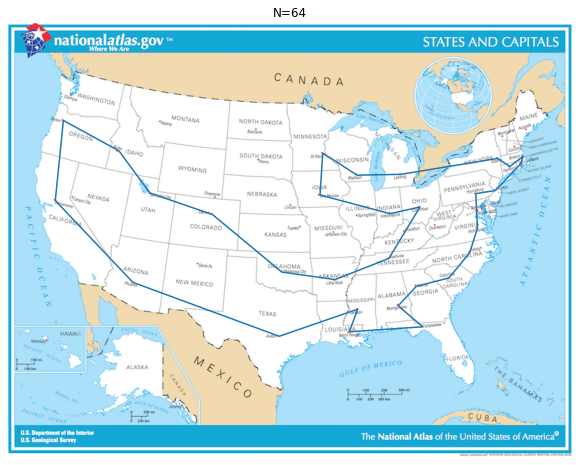

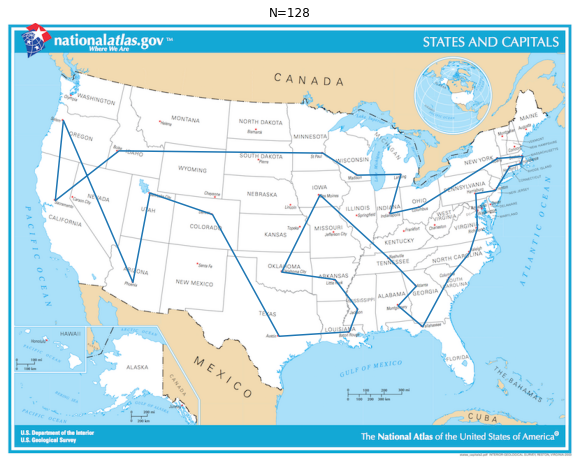

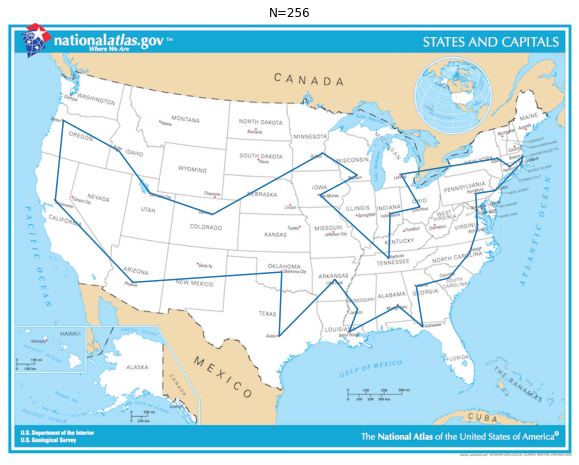

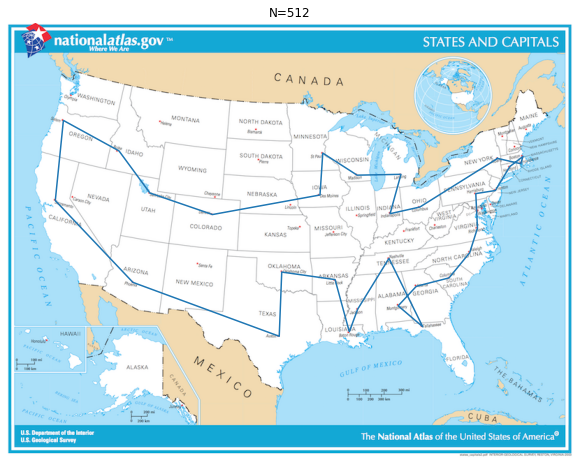

In [86]:
for N in [4,8,16,32,64,128,256,512]:
    plt.figure()
    plt.title(f'N={N}')
    result = AntColonyRunner(cities[:N], timeout=60*60, plot=True)  